In [1]:
#Goal of this notebook: Given early engagement numbers (likes, shares, comments, diggs, upload hour, etc.) 
# → predict how many views the video will eventually reach.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Load training data
df = pd.read_csv("train.csv")

In [3]:
df_clean = df[[
    "digg_count",
    "share_count",
    "repost_count",
    "collect_count",
    "comment_count",
    "duration",
    "create_time",
    "play_count"
]].copy()

In [4]:
# Check cleaned data
print(f"Shape: {df_clean.shape}")
print(f"Missing values: {df_clean.isnull().sum().sum()}")

Shape: (2060, 8)
Missing values: 21


In [5]:
#there are only few rows which have missing/null data, we will just remove them because it won't create a significant 
#difference with our result

In [6]:
df_clean = df_clean.dropna()

In [7]:
# Data cleaned - ready for feature engineering
#FEATURE ENGINEERING: create_time has the date time basically, but we want the hour it was posted (cause that's more crucial)

In [8]:
from datetime import datetime

df_clean["upload_hour"] = df_clean["create_time"].apply(
    lambda x: datetime.fromtimestamp(x).hour
)

df_clean = df_clean.drop("create_time", axis=1)


In [9]:
# Verify feature engineering
print(f"Final shape: {df_clean.shape}")
print(f"Upload hour range: {df_clean['upload_hour'].min()} - {df_clean['upload_hour'].max()}")

Final shape: (2057, 8)
Upload hour range: 0 - 23


In [10]:
#We are going to do ratio features (powerful feature engineering)
#Because they show quality of engagement, not just quantity.

#Examples:
# - A video with 100 comments on 1000 likes is strong.
# - A video with 10 comments on 10,000 likes is weak.

In [11]:
df_clean["like_per_comment"] = df_clean["digg_count"] / (df_clean["comment_count"] + 1)
df_clean["share_per_like"] = df_clean["share_count"] / (df_clean["digg_count"] + 1)

# High value → people like but don’t comment → low interaction
# Low value → comments are high relative to likes → high interaction

# High → people share the video more than they like it → viral content
# Low → people don't find it shareable

In [12]:
df_clean = df_clean.drop("repost_count", axis=1)

In [13]:
from sklearn.model_selection import train_test_split

X = df_clean.drop("play_count", axis=1)

# Log transform target to make distribution more normal
y_log = np.log1p(df_clean["play_count"])
X_train, X_test, y_train_log, y_test_log = train_test_split(
    X, y_log, test_size=0.2, random_state=42
)

In [14]:
# Scale features for better model performance
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()


In [15]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [16]:
# XG BOOOOOOOOOOST - best model for tabular data 
# similar to Random forest tree, however every small decision tree learns from its mistake made by the previous

In [17]:
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error

In [18]:
# 1. Create the model
xgb = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=42
)

In [19]:

# Train baseline XGBoost model
xgb.fit(X_train_scaled, y_train_log)

# Predict and evaluate
preds_log = xgb.predict(X_test_scaled)
preds = np.expm1(preds_log)
actual = np.expm1(y_test_log)

r2_log_baseline = r2_score(y_test_log, preds_log)
rmse_log_baseline = np.sqrt(mean_squared_error(y_test_log, preds_log))

print(f"R2 (log space): {r2_log_baseline:.4f}")
print(f"RMSE (log space): {rmse_log_baseline:.4f}")

R2 (log space): 0.8953
RMSE (log space): 0.3592


In [20]:
# will try to fine tune the XGBoost by finding the optimal parameters

In [21]:
from sklearn.model_selection import RandomizedSearchCV
param_grid = {
    "n_estimators": [300, 500, 800],
    "max_depth": [3, 4, 5, 6, 7],
    "learning_rate": [0.01, 0.03, 0.05, 0.1],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.5, 0.7, 1.0],
    "reg_alpha": [0, 0.1, 0.5],
    "reg_lambda": [1, 1.5, 2]
}

In [22]:
xgb_base = XGBRegressor(
    objective="reg:squarederror",
    random_state=42,
    tree_method="auto"
)

In [23]:
xgb_search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_grid,
    n_iter=20,
    scoring="r2",
    cv=3,
    verbose=0,  # Reduced verbosity
    random_state=42,
    n_jobs=-1
)

In [24]:
xgb_search.fit(X_train_scaled, y_train_log)


,estimator,"XGBRegressor(...ree=None, ...)"
,param_distributions,"{'colsample_bytree': [0.5, 0.7, ...], 'learning_rate': [0.01, 0.03, ...], 'max_depth': [3, 4, ...], 'n_estimators': [300, 500, ...], ...}"
,n_iter,20
,scoring,'r2'
,n_jobs,-1
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [25]:
# Best hyperparameters found
print(f"Best CV R2 score: {xgb_search.best_score_:.4f}")
print(f"Best parameters: {xgb_search.best_params_}")

Best CV R2 score: 0.8936
Best parameters: {'subsample': 0.6, 'reg_lambda': 2, 'reg_alpha': 0.1, 'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.01, 'colsample_bytree': 1.0}


In [26]:
# Evaluate best model
best_xgb = xgb_search.best_estimator_

preds_log = best_xgb.predict(X_test_scaled)
preds = np.expm1(preds_log)
actual = np.expm1(y_test_log)

r2_log = r2_score(y_test_log, preds_log)
rmse_log = np.sqrt(mean_squared_error(y_test_log, preds_log))

print(f"R2 (log space): {r2_log:.4f}")
print(f"RMSE (log space): {rmse_log:.4f}")
print(f"\nNote: R2 in log space ({r2_log:.4f}) is the correct metric since model was trained on log-transformed data.")

R2 (log space): 0.9011
RMSE (log space): 0.3491

Note: R2 in log space (0.9011) is the correct metric since model was trained on log-transformed data.


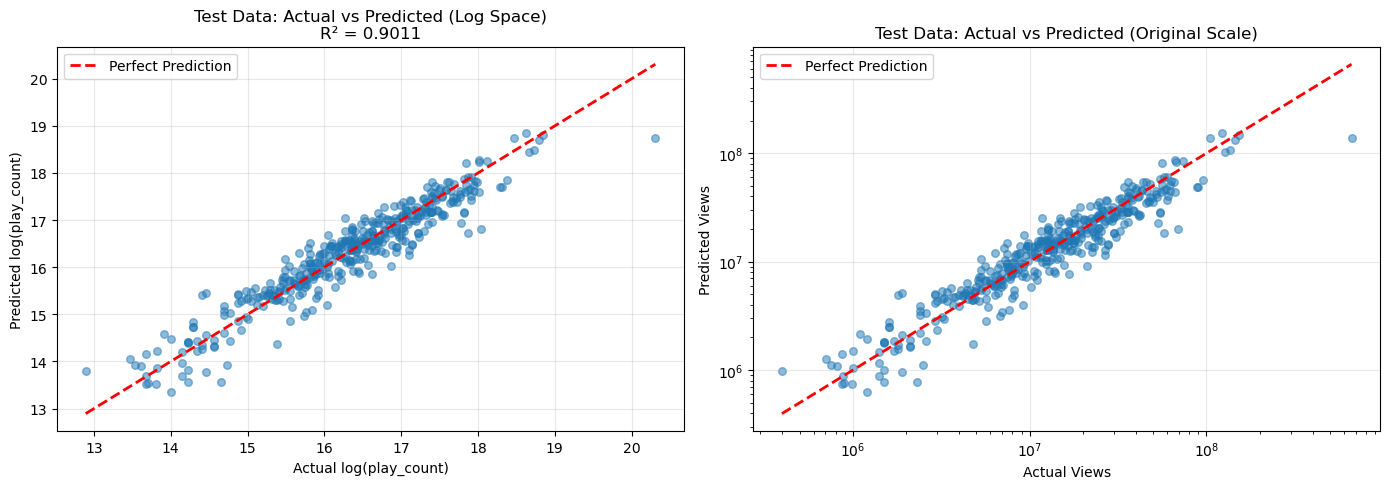

In [27]:
# Visualize model performance
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Log space (where model was trained)
ax1 = axes[0]
ax1.scatter(y_test_log, preds_log, alpha=0.5, s=30)
min_val = min(y_test_log.min(), preds_log.min())
max_val = max(y_test_log.max(), preds_log.max())
ax1.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')
ax1.set_xlabel('Actual log(play_count)')
ax1.set_ylabel('Predicted log(play_count)')
ax1.set_title(f'Test Data: Actual vs Predicted (Log Space)\nR² = {r2_log:.4f}')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Original scale
ax2 = axes[1]
ax2.scatter(actual, preds, alpha=0.5, s=30)
max_val = max(max(actual), max(preds))
min_val = min(min(actual), min(preds))
ax2.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')
ax2.set_xlabel('Actual Views')
ax2.set_ylabel('Predicted Views')
ax2.set_title('Test Data: Actual vs Predicted (Original Scale)')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


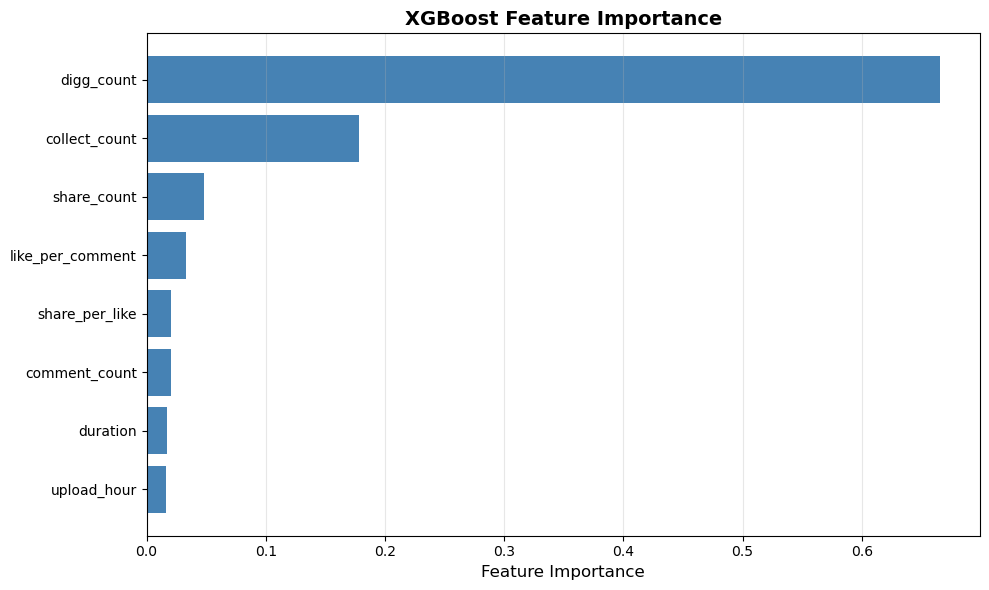

In [28]:
# Feature importance visualization
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': best_xgb.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'], feature_importance['importance'], color='steelblue')
plt.xlabel('Feature Importance', fontsize=12)
plt.title('XGBoost Feature Importance', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()
